In [1]:
import numpy as np
import h5py
import trimesh
import matplotlib.pyplot as plt
from random import random, uniform
import dlib
from scipy.optimize import lsq_linear

/home/hao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%run optimizers/gradient_descent.ipynb
%run initializers/pose_parameters.ipynb
%run initializers/shape_parameters.ipynb

Using TensorFlow backend.


In [3]:
class Face3DMM:
    """
    Optimizer definition for finding the optimal PCA weights to construct a 3D model from 2D image.
    """
    
    def __init__(self, basel_model_filepath):
        """
        """
        
        # load the basel model
        model = h5py.File(basel_model_filepath, 'r')
        
        # get indexes of feature points
        feature_point_indexes = self.get_feature_point_indexes(model)
        
        # load shape data and extract only the feature points
        self.shape_mean = np.array(model['shape']['model']['mean'])[feature_point_indexes]
        self.shape_pcaBasis = np.array(model['shape']['model']['pcaBasis'])[feature_point_indexes]
        self.shape_pcaVariance = np.array(model['shape']['model']['pcaVariance'])
        
        # the number of shape components
        self.num_features = int(len(feature_point_indexes)/3)
        self.num_components = len(self.shape_pcaVariance)
        
        # reshape the components for matrix operations
        self.shape_mean = self.shape_mean.reshape(self.shape_mean.shape+(1,))
        self.shape_pcaVariance = self.shape_pcaVariance.reshape(self.shape_pcaVariance.shape+(1,))
    
    
    def get_3DMM(self, face_image):
        """
        Gets a 3DMM for an image of a face.
        
        Args:
          face_image: the image of the face
        
        Returns:
          A 3DMM for the face in the 2D image
        """
        
        # TODO
        
        return None
    
    
    def optimize(self, target_features, i=25, j=1000):
        """
        Gets optimal weights for a 3DMM reconstruction from the 2D input features.
        
        Args:
          target_features: the 2D target features [x1, y1, x2, y2, ...]            (2*f,1)
          i: the number of additional iterations for pose and shape estimations
          j: the number of optimizer iterations
          where
            f: the number of features
        
        Returns:
          Optimal weights for a 3DMM face reconstruction
        """
        
        # initial pose and shape parameters
        ri, ti, si = initialize_pose_parameters(target_features, np.zeros((self.num_components,1)), self.shape_mean, self.shape_pcaBasis)
        ai = initialize_shape_parameters(target_features, self.shape_mean, self.shape_pcaBasis, self.shape_pcaVariance, ri, ti, si)
        for _ in range(i):
            ri, ti, si = initialize_pose_parameters(target_features, ai, self.shape_mean, self.shape_pcaBasis)
            ai = initialize_shape_parameters(target_features, self.shape_mean, self.shape_pcaBasis, self.shape_pcaVariance, ri, ti, si)
        
        return gradient_descent(
            target_features,
            self.shape_mean,
            self.shape_pcaBasis,
            self.shape_pcaVariance,
            ai,
            ri,
            ti,
            si,
            optimizer='adam',
            num_iterations=j)
    
    
    def feature_point_transformation(self, a, r, t, s):
        """
        Gets a 2D transformation of each feature point.
        
        Args:
          a: the pca weights              (c, 1)
          r: the rotation matrix          (3, 3)
          t: the translation matrix       (2, 1)
          s: the scale matrix             (1)
          where
            f: the number of features
            c: the number of components
          
        Returns:
          A 2D projection for each feature point.
        """
        
        # calculate [u1, v2, w3, ..., un, vn, wn]
        points = self.shape_mean + np.matmul(self.shape_pcaBasis, a)
        
        # format the points into (3, f)
        points = np.reshape(points, (3, self.num_features), order='F')
        
        # SOP, 3D to 2D projection
        points = s * np.matmul(np.array([[1.,0.,0.],[0.,1.,0.]]), np.matmul(r,points)) + s * np.repeat(t,self.num_features,axis=-1)
        
        # return the transformed points
        return points
    
    
    def get_feature_point_indexes(self, model):
        """
        Gets the indexes of the points that represent the features.

        Args:
          model: the loaded h5 basel face model

        Returns:
          The point index for each feature
        """

        # get the features
        features = model['metadata']['landmarks']['text'].value.decode('utf-8')
        features = features.split('\n')[:-1]
        features = [feature[feature.find('1')+2:].split(' ') for feature in features]
        features = np.array(features).astype(np.float32)
        
        # get the points
        points = np.array(model['shape']['representer']['points'])
        
        # index holder
        indexes = []

        # for each feature
        for feature in features:

            # verify the feature was found
            found = False

            # search each point to match the 
            for index, point in enumerate(points.T):

                # test equality
                if all(point == feature):

                    # append point index and break
                    # need to append three consecutive points because pca is in a flatten list
                    indexes.append(3*index)    # u coordinate of point
                    indexes.append(3*index+1)  # v coordinate of point
                    indexes.append(3*index+2)  # w coordinate of point
                    found = True
                    break

            # test the point was found and if not raise error
            if not found:
                raise Exception('Could not find the feature point: %s' % str(feature))
                
        # sort the indexes, for no reason other than asthetic appeal
        indexes.sort()
        
        # return the indexes
        return indexes
    
        

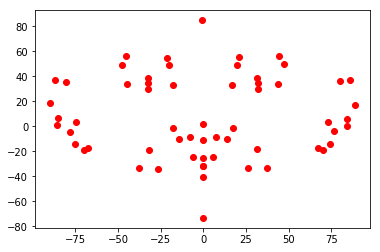

In [4]:
x = Face3DMM(basel_model_filepath='../basel/model2017-1_bfm_nomouth.h5')
weights = np.array([uniform(0, 0) for i in range(199)]).reshape((199,1))
points = x.feature_point_transformation(
    a=weights,
    r=np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ]),
    t=np.array([0,0]).reshape((2,1)),
    s=1.
)
plt.plot(points[0,:], points[1,:], 'ro')
plt.show()

(199, 1)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.20377266]
 [-0.6840127 ]]
1.099196616404046


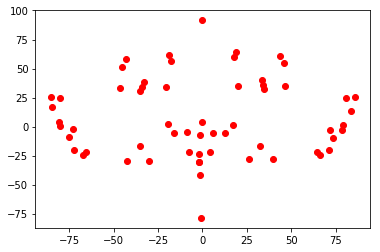

In [88]:
a, r, t, s = x.optimize(points.flatten(), i=100, j=10000)
print(a.shape)
print(r)
print(t)
print(s)
test_points = x.feature_point_transformation(
    a=a,
    r=r,
    t=t,
    s=s
)
plt.plot(test_points[0,:], test_points[1,:], 'ro')
plt.show()

In [9]:
model = h5py.File('../basel/model2017-1_bfm_nomouth.h5', 'r')
features = model['metadata']['landmarks']['text'].value.decode('utf-8')
for f in features.split('\n'):
    if '.eye.' in f:
        print(f)

left.eye.bottom 1 30.8319283 28.8719139 93.7743988
left.eye.corner_inner 1 16.1573315 31.8608284 92.9888535
left.eye.corner_outer 1 43.0308571 32.5797234 86.7202759
left.eye.pupil.center 1 30.8336086 33.2174835 95.220459
left.eye.top 1 30.8075256 37.1855469 95.3033066
right.eye.bottom 1 -31.677433 28.7479153 93.8427048
right.eye.corner_inner 1 -17.0949841 31.7714787 93.1282425
right.eye.corner_outer 1 -44.0275459 32.4399872 86.6149063
right.eye.pupil.center 1 -31.5763073 33.1489372 95.2801437
right.eye.top 1 -31.5933933 37.0980988 95.341156
